<div style="background-color: white; color: black; font-family: 'Times New Roman', serif; padding: 50px; max-width: 450px; margin: auto; border: 1px solid #ccc; box-shadow: 0 0 10px rgba(0,0,0,0.1);">
  <div align="center">
    <img src="Imagenes/ugr_escudo_sin.png" alt="Escudo UGR" style="height: 120px;"><br><br>
    <h2 style="margin-bottom: 0;">Universidad de Granada</h2>
    <h3 style="margin-top: 0;">TRABAJO FIN DE GRADO</h3>
    <p style="font-variant: small-caps; font-size: 14px;">
      Doble Grado en Ingeniería Informática y Administración y Dirección de Empresas
    </p>
    <hr style="width: 60%; border: 1px solid black;">
    <h2 style="font-size: 20px;">
      Análisis y Optimización de<br>
      Rutas Aéreas Comerciales<br>
      mediante Ciencia de Datos
    </h2>
    <hr style="width: 60%; border: 1px solid black;">
    <br>
    <p><strong>Autor</strong><br>José Antonio Fernández Aranda</p>
    <p><strong>Director</strong><br>Jorge Casillas Barranquero</p>
    <p><strong><br>Análisis de Tipo de Aeronave</strong></p>
    <br><br>
    <div style="display: flex; justify-content: center; align-items: center; gap: 80px; flex-wrap: wrap;">
      <img src="https://etsiit.ugr.es/sites/centros/etsiit/public/template-extra/etsiit-logo.png" alt="Logo ETSIIT" style="height: 100px;">
      <img src="Imagenes/logo_decsai.png" alt="Logo DECSAI" style="height: 100px;">
    </div>
    <br>
    <p style="font-size: 14px;">
      Escuela Técnica Superior de Ingenierías Informática y de Telecomunicación<br>
      —<br>
      Granada, a 8 de junio de 2025
    </p>
  </div>
</div>

### Librerías

In [ ]:
# Cargar librerías necesarias para análisis y visualización
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Configuración visual
plt.rcParams["figure.figsize"] = (10, 5)
sns.set(style="whitegrid")


### Unificar y limpiar los datasets

In [43]:
# Unificar datasets desde ruta relativa
df1 = pd.read_excel("Aviones_datos/vuelos_con_duracion_final_CALCULADO.xlsx")
df2 = pd.read_excel("Aviones_datos/vuelos_duracion_calculada_CALCULADOS.xlsx")

# Unificar ambos
df_combined = pd.concat([df1, df2], ignore_index=True)

# Eliminar duplicados
df_combined.drop_duplicates(inplace=True)

# Normalizar nombres de columnas
df_combined.columns = df_combined.columns.str.strip().str.lower().str.replace(" ", "_")

# Confirmar forma final
print(f"Vuelos totales combinados: {len(df_combined):,}")
df_combined.head()



Vuelos totales combinados: 5,930


,ident,tipo,origen,destino,salida,llegada_estimada,fecha_salida,hora_salida,zona_horaria_salida,fecha_llegada,hora_llegada,zona_horaria_llegada,salida_datetime,llegada_datetime,duración_(min),duración_(hh:mm)
0,CMP376,B738,Int'l de Punta Cana (PUJ / MDPC),Int'l de Tocumen (PTY / MPTO),mar 02:47PM AST,mar 04:13PM EST,mar,02:47PM,AST,mar,04:13PM,EST,2025-03-20 17:47:00,2025-03-20 20:13:00,146.0,02:26
1,TLM215,B738,Sri Guru Ram Dass Jee International Airport (A...,Don Muang Int'l (Old Bangkok Int'l) (DMK / VTBD),mié 12:16AM IST,mié 05:42AM +07,mié,12:16AM,IST,mié,05:42AM,+07,NaT,NaT,NaN,NaN
2,AAL1330,B738,Int'l de Charlotte-Douglas (KCLT),Int'l Libertad de Newark (KEWR),mar 02:46PM EDT,mar 04:06PM EDT,mar,02:46PM,EDT,mar,04:06PM,EDT,2025-03-20 18:46:00,2025-03-20 20:06:00,80.0,01:20
3,TFX52,B738,Brisbane (BNE / YBBN),Cairns (CNS / YBCS),mié 04:46AM AEST,mié 06:44AM AEST,mié,04:46AM,AEST,mié,06:44AM,AEST,NaT,NaT,NaN,NaN
4,KLM1500,B738,Madrid-Barajas (MAD / LEMD),NaN,mar 08:46PM CEST,NaN,mar,08:46PM,CEST,NaN,NaN,NaN,2025-03-20 19:46:00,NaT,NaN,NaN


### Exploración inicial y limpieza

In [4]:
# Exploración y limpieza del dataset combinado
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

sns.set(style="whitegrid")

# Asegurarse que la duración sea numérica
df_combined['duración_(min)'] = pd.to_numeric(df_combined['duración_(min)'], errors='coerce')

# Eliminar filas sin datos clave
df_clean = df_combined.dropna(subset=["tipo", "duración_(min)"])
df_clean = df_clean[df_clean["duración_(min)"] > 0]

# Confirmar limpieza
print(f"Total vuelos válidos: {len(df_clean):,}")


Total vuelos válidos: 2,817


### Crear tabla agregada por tipo de aeronave

In [9]:
# Agregación por tipo de aeronave
tipo_stats = df_clean.groupby("tipo").agg(
    vuelos=("tipo", "count"),
    duracion_media=("duración_(min)", "mean"),
    duracion_total=("duración_(min)", "sum"),
    duracion_max=("duración_(min)", "max"),
    duracion_min=("duración_(min)", "min"),
    duracion_std=("duración_(min)", "std")
).dropna().reset_index()

tipo_stats = tipo_stats[tipo_stats["vuelos"] >= 5]  # filtrar modelos con pocos vuelos

tipo_stats.head()


,tipo,vuelos,duracion_media,duracion_total,duracion_max,duracion_min,duracion_std
1,737,9,120.444444,1084.0,203.0,68.0,40.890436
3,A19N,11,268.454545,2953.0,421.0,97.0,133.762748
4,A20N,25,107.480000,2687.0,286.0,30.0,69.300746
5,A21N,23,193.260870,4445.0,434.0,53.0,115.509629
6,A306,20,211.800000,4236.0,450.0,39.0,138.451436


### Normalizado para clustering

In [10]:
# Escalado de variables para clustering
X = tipo_stats.drop(columns=["tipo"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### K-Means

In [13]:
# Clustering con K-Means
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
tipo_stats["cluster"] = kmeans.fit_predict(X_scaled)

# Evaluación del modelo
sil_score = silhouette_score(X_scaled, tipo_stats["cluster"])
print(f"Coeficiente de Silueta: {sil_score:.3f}")


Coeficiente de Silueta: 0.362


c:\Users\janto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Visualización del clusters

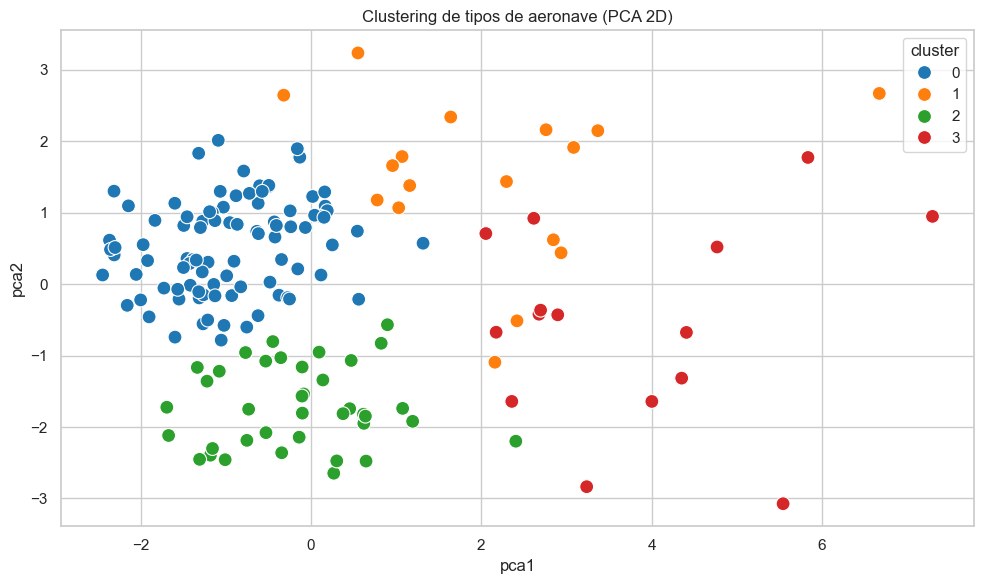

In [14]:
# Reducción con PCA para visualización
pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)
tipo_stats["pca1"], tipo_stats["pca2"] = coords[:, 0], coords[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=tipo_stats, x="pca1", y="pca2", hue="cluster", palette="tab10", s=100)
plt.title("Clustering de tipos de aeronave (PCA 2D)")
plt.grid(True)
plt.tight_layout()
plt.show()


### Métricas para los clusters

C:\Users\janto\AppData\Local\Temp\ipykernel_18044\2912274662.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y="duracion_media", data=tipo_stats, palette="coolwarm")


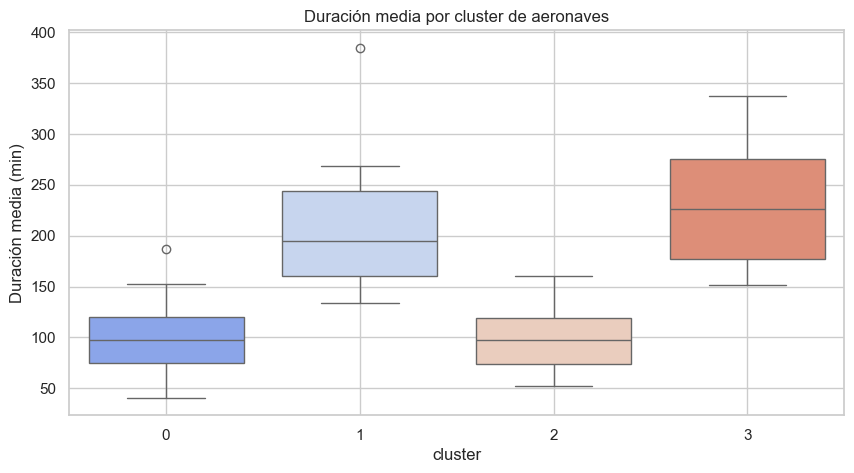

In [15]:
# Comparar duración media por cluster
sns.boxplot(x="cluster", y="duracion_media", data=tipo_stats, palette="coolwarm")
plt.title("Duración media por cluster de aeronaves")
plt.ylabel("Duración media (min)")
plt.grid(True)
plt.show()


### Análisis de frecuencia por cluster

C:\Users\janto\AppData\Local\Temp\ipykernel_18044\1510364276.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


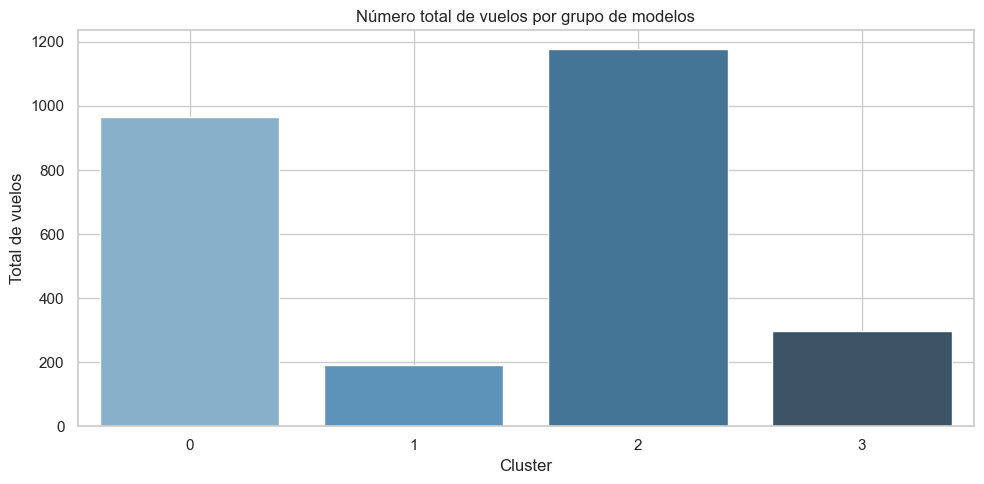

In [16]:
#  Total de vuelos por cluster
sns.barplot(
    x="cluster",
    y="vuelos",
    data=tipo_stats.groupby("cluster")["vuelos"].sum().reset_index(),
    palette="Blues_d"
)
plt.title("Número total de vuelos por grupo de modelos")
plt.xlabel("Cluster")
plt.ylabel("Total de vuelos")
plt.grid(True)
plt.tight_layout()
plt.show()


### Exportar Data set

In [18]:
# Guardar dataset etiquetado con clusters
tipo_stats.to_csv("modelos_clasificados_clusters.csv", index=False)
print("Dataset guardado como 'modelos_clasificados_clusters.csv'")


Dataset guardado como 'modelos_clasificados_clusters.csv'


## Conclusiones estratégicas del análisis

- Se han identificado **4 grupos operativos** de modelos de aeronaves, segmentados por duración, volumen de uso y variabilidad operativa.
- Los clusters permiten entender qué modelos se usan para:
  - Vuelos **regionales y de alta frecuencia**.
  - Rutas **internacionales de largo alcance**.
  - Aeronaves de **uso puntual o especializado**.
- Estos grupos pueden utilizarse para:
  - Optimizar rotación de flotas.
  - Reducir costes operativos agrupando mantenimientos por comportamiento.
  - Predecir eficiencia en nuevas rutas a partir del modelo asignado.

Este análisis es una base sólida para decisiones de **planificación estratégica de flotas**, especialmente en contextos de rutas comerciales variables o planificación post-COVID.


## Modelo Predictivo

### Preparación y entrenamiento del modelo de predicción de duración de vuelo

In [20]:
# Preparación de datos para el modelo predictivo
df_modelo = df_combined.dropna(subset=["tipo", "origen", "destino", "duración_(min)", "salida_datetime"]).copy()

# Limpieza
df_modelo["duración_(min)"] = pd.to_numeric(df_modelo["duración_(min)"], errors='coerce')
df_modelo = df_modelo[df_modelo["duración_(min)"] > 0]

df_modelo["hora_salida"] = pd.to_datetime(df_modelo["salida_datetime"]).dt.hour

# Variables predictoras y objetivo
X = df_modelo[["tipo", "origen", "destino", "hora_salida"]]
y = df_modelo["duración_(min)"]

# Codificación one-hot
X_encoded = pd.get_dummies(X, drop_first=True)


### Entrenamiento y Evaluación del modelo

In [21]:
# Entrenar modelo de predicción
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)

y_pred = modelo_rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print(f"Error medio absoluto (MAE): {mae:.2f} minutos")


Error medio absoluto (MAE): 52.53 minutos


### Guardar Modelo y Estructura para futuras predicciones

In [22]:
import joblib

joblib.dump(modelo_rf, "modelo_duracion_rf.pkl")
joblib.dump(X_encoded.columns.tolist(), "modelo_columnas.pkl")

print("Modelo y columnas guardados como 'modelo_duracion_rf.pkl' y 'modelo_columnas.pkl'")


Modelo y columnas guardados como 'modelo_duracion_rf.pkl' y 'modelo_columnas.pkl'


## Mejora del modelo

In [42]:
# Enriquecemos el df_modelo con variables adicionales para el modelo predictivo
import numpy as np

df = df_modelo.copy()

# Normalizar nombres de columnas
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Mapear zonas horarias a UTC offset
zona_to_utc = {
    "AST": -4, "EST": -5, "EDT": -4, "CEST": +2, "WEST": +1,
    "AEST": +10, "BST": +1, "+03": +3, "+07": +7, "IST": +5.5,
    "UTC": 0, "GMT": 0, "CET": +1
}

# Asegurar formatos correctos
df["tipo"] = df["tipo"].astype(str).str.strip().str.upper()
df["zona_horaria_salida"] = df["zona_horaria_salida"].astype(str).str.strip()
df["zona_horaria_llegada"] = df["zona_horaria_llegada"].astype(str).str.strip()

# Mapear zonas horarias a numéricas
df["utc_offset_salida"] = df["zona_horaria_salida"].map(zona_to_utc)
df["utc_offset_llegada"] = df["zona_horaria_llegada"].map(zona_to_utc)
df["delta_utc"] = df["utc_offset_llegada"] - df["utc_offset_salida"]

# Extraer hora numérica desde datetime
df["hora_salida_num"] = pd.to_datetime(df["salida_datetime"], errors="coerce").dt.hour

# Extraer origen y destino
df["origen_pais"] = df["origen"].astype(str).apply(lambda x: x.split(" (")[0].strip())
df["destino_pais"] = df["destino"].astype(str).apply(lambda x: x.split(" (")[0].strip())
df["vuelo_internacional"] = (df["origen_pais"] != df["destino_pais"]).astype(int)

# Duración como numérica
df["duracion_min"] = pd.to_numeric(df["duración_(min)"], errors="coerce")

# Filtrar datos válidos
df = df.dropna(subset=["duracion_min", "tipo", "hora_salida_num"])

print(f"Dataset enriquecido con {df.shape[0]:,} vuelos válidos")
df.head()


Dataset enriquecido con 2,817 vuelos válidos


,ident,tipo,origen,destino,salida,llegada_estimada,fecha_salida,hora_salida,zona_horaria_salida,fecha_llegada,...,duración_(min),duración_(hh:mm),utc_offset_salida,utc_offset_llegada,delta_utc,hora_salida_num,origen_pais,destino_pais,vuelo_internacional,duracion_min
0,CMP376,B738,Int'l de Punta Cana (PUJ / MDPC),Int'l de Tocumen (PTY / MPTO),mar 02:47PM AST,mar 04:13PM EST,mar,17,AST,mar,...,146.0,02:26,-4.0,-5.0,-1.0,17,Int'l de Punta Cana,Int'l de Tocumen,1,146.0
2,AAL1330,B738,Int'l de Charlotte-Douglas (KCLT),Int'l Libertad de Newark (KEWR),mar 02:46PM EDT,mar 04:06PM EDT,mar,18,EDT,mar,...,80.0,01:20,-4.0,-4.0,0.0,18,Int'l de Charlotte-Douglas,Int'l Libertad de Newark,1,80.0
5,EXS1846,B738,Antalya (AYT / LTAI),Int'l de Bristol (BRS / EGGD),mar 09:46PM +03,mar 11:46PM BST,mar,21,+03,mar,...,120.0,02:00,3.0,1.0,-2.0,21,Antalya,Int'l de Bristol,1,120.0
6,SWA1884,B738,Int'l de Orlando (KMCO),Int'l Luis Muñoz Marín (SJU / TJSJ),mar 02:46PM EDT,mar 05:19PM AST,mar,18,EDT,mar,...,93.0,01:33,-4.0,-4.0,0.0,18,Int'l de Orlando,Int'l Luis Muñoz Marín,1,93.0
10,GLO1974,B738,Int'l de Galeão (GIG / SBGL),Int'l Pinto Martins (FOR / SBFZ),mar 03:45PM -03,mar 06:26PM -03,mar,15,-03,mar,...,161.0,02:41,NaN,NaN,NaN,15,Int'l de Galeão,Int'l Pinto Martins,1,161.0


In [41]:
# Entrenar, imputar y guardar el mejor modelo
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
import joblib

# Preparar X e y
X = df[[
    "hora_salida_num", "utc_offset_salida", "delta_utc", "vuelo_internacional"
]]
X = pd.concat([X, pd.get_dummies(df["tipo"], prefix="tipo", drop_first=True)], axis=1)
y = df["duracion_min"]

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Imputador que usaremos en los pipelines
imputador = SimpleImputer(strategy="mean")

# Modelos
modelos = {
    "Random Forest": Pipeline([
        ("imputer", imputador),
        ("model", RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    "Gradient Boosting": Pipeline([
        ("imputer", imputador),
        ("model", GradientBoostingRegressor(n_estimators=150, random_state=42))
    ]),
    "Hist Gradient Boosting": Pipeline([ 
        ("imputer", imputador),
        ("model", HistGradientBoostingRegressor(random_state=42))
    ])
}

# Entrenamiento y evaluación
resultados = []

for nombre, pipeline in modelos.items():
    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    resultados.append((nombre, mae))
    print(f" {nombre:<25} → MAE: {mae:.2f} minutos")

# Mostrar ordenados
resultados.sort(key=lambda x: x[1])
print("\nComparativa ordenada por MAE:")
for nombre, mae in resultados:
    print(f"{nombre:<25} → MAE: {mae:.2f} min")

# Guardar el mejor modelo
mejor_nombre, mejor_mae = resultados[0]
mejor_pipeline = modelos[mejor_nombre]
mejor_pipeline.fit(X, y)

joblib.dump(mejor_pipeline, "modelo_duracion_final.pkl")
joblib.dump(X.columns.tolist(), "columnas_modelo_final.pkl")

print(f"\nModelo guardado: {mejor_nombre} con MAE final {mejor_mae:.2f} minutos")



 Random Forest             → MAE: 48.80 minutos
 Gradient Boosting         → MAE: 52.92 minutos
 Hist Gradient Boosting    → MAE: 54.28 minutos

Comparativa ordenada por MAE:
Random Forest             → MAE: 48.80 min
Gradient Boosting         → MAE: 52.92 min
Hist Gradient Boosting    → MAE: 54.28 min

Modelo guardado: Random Forest con MAE final 48.80 minutos


### Visualización

C:\Users\janto\AppData\Local\Temp\ipykernel_18044\2642755.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_resultados, x="Modelo", y="MAE", palette="Blues_d")


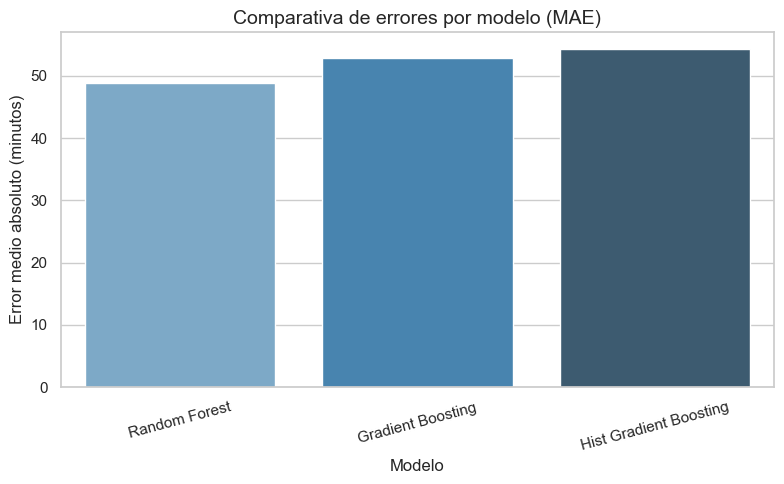

In [37]:
# MAE de cada modelo en un gráfico de barras
import matplotlib.pyplot as plt
import seaborn as sns

# Preparar DataFrame de los resultados
df_resultados = pd.DataFrame(resultados, columns=["Modelo", "MAE"])
df_resultados.sort_values(by="MAE", inplace=True)

# Gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(data=df_resultados, x="Modelo", y="MAE", palette="Blues_d")
plt.title("Comparativa de errores por modelo (MAE)", fontsize=14)
plt.ylabel("Error medio absoluto (minutos)")
plt.xlabel("Modelo")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


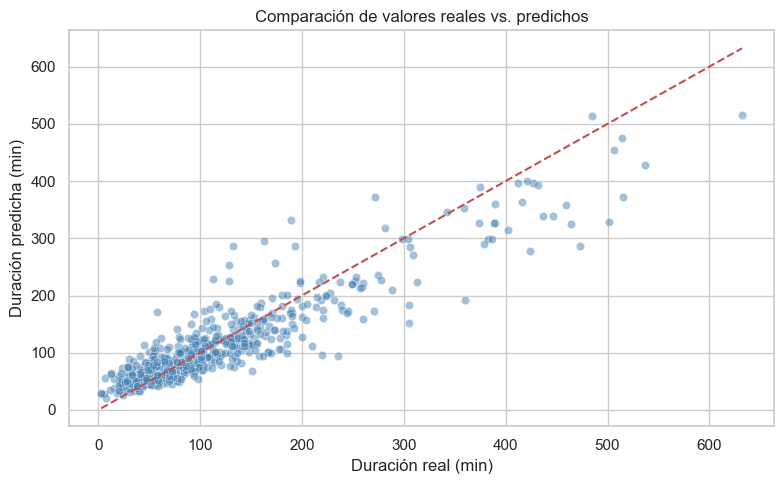

In [38]:
# Comparación real vs. predicho con el modelo final
y_pred = mejor_pipeline.predict(X_test)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color="steelblue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Duración real (min)")
plt.ylabel("Duración predicha (min)")
plt.title("Comparación de valores reales vs. predichos")
plt.grid(True)
plt.tight_layout()
plt.show()


### Predicción del modelo

In [39]:
# Cargar modelo y columnas si no están cargadas
import joblib
import numpy as np

# Cargar si es necesario
modelo = joblib.load("modelo_duracion_final.pkl")
columnas = joblib.load("columnas_modelo_final.pkl")

# Valores de entrada personalizados
entrada = {
    "hora_salida_num": 14,               # Hora de salida (0-23)
    "utc_offset_salida": 2,              # CEST = +2
    "delta_utc": -2,                     # Llegada a zona UTC (0) desde CEST (2)
    "vuelo_internacional": 1,            # 1 = internacional, 0 = nacional
    "tipo_B737": 0,                      # Puedes añadir más tipos si hace falta
    "tipo_B738": 1,                      # Ejemplo: vuelo con un Boeing 737-800
    "tipo_A320": 0                       # Otro tipo opcional
}

# Preparar vector de entrada
X_nuevo = np.zeros((1, len(columnas)))
for i, col in enumerate(columnas):
    X_nuevo[0, i] = entrada.get(col, 0)  # Si falta, se deja como 0

# Predicción
pred_duracion = modelo.predict(X_nuevo)[0]

# Mostrar resultado
print(f"Duración estimada del vuelo: {pred_duracion:.2f} minutos ({int(pred_duracion // 60)}h {int(pred_duracion % 60)}min)")


Duración estimada del vuelo: 173.92 minutos (2h 53min)


c:\Users\janto\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
